In [1]:
#Run the following code to print multiple outputs from a cell
get_ipython().ast_node_interactivity = 'all'

# Predictive Performance

Over the past several classes, we've built a number of classification models that we assessed using accuracy. For example, when predicting whether or not someone paid their credit card bill, we got the following results:

* Decision Tree: 71% accurate
* Random Forest: 80% accurate
* Support Vector Machine (w/o normalized features): 78%
* Support Vector Machine (w/ normalized features): 82% accurate
* Neural Network: 82% accurate

The major drawback to using this number -- as we've seen -- is the fact that it doesn't take into account how accurate (or inaccurate) the model is for paid vs. missed payments. In our example, it's more costly for the bank to misclassify someone as paying their bill when they didn't pay. However, the SVM model without normalized features predicted *no one* would miss their bill and yet still achieved 78% accuracy. This often occurs with imbalanced data, like we had with the credit card customers.

Two measures that try to account for this are the ROC (receiver operating characteristic) curve and the AUC (area under the curve).

## Importing & Setting up the Data
Import the file, "creditCardDefaultReduced.csv", and save it in a variable called `df`. 

In [2]:
import pandas as pd
df = pd.read_csv("creditCardDefaultReduced.csv")
df

,Limit_Bal,Education,Marriage,Age,Pay_0,Bill_Amt1,Pay_Amt1,Payment,Card
0,20000,University,married,24,Delay2,3913,0,Missed,Normal
1,120000,University,single,26,ontime,2682,0,Missed,Normal
2,90000,University,single,34,Delay0,29239,1518,Paid,Normal
3,50000,University,married,37,Delay0,46990,2000,Paid,Normal
4,50000,University,married,57,ontime,8617,2000,Paid,Gold
...,...,...,...,...,...,...,...,...,...
29995,220000,High school,married,39,Delay0,188948,8500,Paid,Gold
29996,150000,High school,single,43,ontime,1683,1837,Paid,Gold
29997,30000,University,single,37,Delay4,3565,0,Missed,Gold
29998,80000,High school,married,41,Delay1,-1645,85900,Missed,Gold


Next, create your `outcome` and `features` variables:

In [3]:
outcome = df["Payment"]
numericFeatures = df[["Limit_Bal", "Bill_Amt1", "Pay_Amt1", "Age"]]
dummies = pd.get_dummies(df[["Marriage", "Card", "Pay_0"]], drop_first = True)
features = pd.concat([numericFeatures, dummies], axis = 1)

Our next step is to partition the data into training and test data sets:

In [4]:
from sklearn.model_selection import train_test_split
featuresTrain, featuresTest, outcomeTrain, outcomeTest = train_test_split(features, 
                                                                          outcome, 
                                                                          test_size = 0.33, 
                                                                          random_state = 42)

Let's scale our features and use these features for all of our models:

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
featuresTrain_norm = scaler.fit_transform(featuresTrain)
featuresTest_norm = scaler.transform(featuresTest)

## Building the Models

The following code cell builds our 4 models...we will be using these to assess the models' fit using ROC curves and the AUC:

In [6]:
# Decision Tree
import sklearn.tree
modTree = sklearn.tree.DecisionTreeClassifier(random_state = 42)
modTree.fit(featuresTrain_norm, outcomeTrain)

# Random Forest
import sklearn.ensemble
modForest = sklearn.ensemble.RandomForestClassifier(random_state = 42)
modForest.fit(featuresTrain_norm, outcomeTrain)

# Support Vector Machine
import sklearn.svm
modSVM = sklearn.svm.SVC(random_state = 42)
modSVM.fit(featuresTrain_norm, outcomeTrain)

# Neural Network
import sklearn.neural_network
modNN = sklearn.neural_network.MLPClassifier(random_state = 42, hidden_layer_sizes = (30,30))
modNN.fit(featuresTrain_norm, outcomeTrain)

DecisionTreeClassifier(random_state=42)

RandomForestClassifier(random_state=42)

SVC(random_state=42)

MLPClassifier(hidden_layer_sizes=(30, 30), random_state=42)

## ROC Curves

Another limitation of the accuracy score is that it only provides a measure of the model's performance at a 50% threshold...i.e., the credit card customer is characterized as missing the payment unless the probability of payment exceeds 50%. There are, of course, other thresholds the bank could consider. For example, if it's costly to misclassify customers who will miss their payment, maybe the bank should use a threshold of 60% instead.

The ROC curve plots a model's true positive rate against its false positive rate at different thresholds (from 0% to 100%). We'll be using the `roc_curve()` function from `sklearn.metrics`, which returns an array of false positive rates, true positive rates, and the thresholds at which those rates were calculated.

Let's see how this works, starting with the Decision Tree (`modTree`). We first need to get predictions from our model so that we can compare them to the actual outcomes. Up until now, we've calculated the predictions as follows:

In [7]:
modTree.predict(featuresTest_norm)[0:19]
# [0:19] displays the first 19 predictions

array(['Missed', 'Paid', 'Paid', 'Paid', 'Paid', 'Paid', 'Paid', 'Paid',
       'Paid', 'Missed', 'Missed', 'Missed', 'Paid', 'Missed', 'Paid',
       'Paid', 'Paid', 'Paid', 'Paid'], dtype=object)

Notice the predictions are either `Paid` or `Missed`. But we want to be able to use probabilities in our calculations. So let's use the `predict_proba()` function instead:

In [8]:
predTree = modTree.predict_proba(featuresTest_norm)
predTree[0:19]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

For each prediction, the first number in the `[]`s is the probability of `Missed` and the second number is the probability of `Paid`. (Although only 0's and 1s display, these numbers are being rounded to the nearest whole number.) 

For the `roc_curve()` function, we only need the probability of `Paid`. We can do this by providing "column criteria"...we want the 2nd column and, because Python always starts counting at 0, that means we need column 1:

In [9]:
predTree[0:19, 1]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1.])

For the "row criteria", we've been displaying rows 0 to 19...if you want all rows, you can just type a `:`, like this:

In [10]:
predTree[:, 1]
# this will show a preview of the first 3 and the last 3 probabilities for Paid

array([0., 1., 1., ..., 1., 1., 1.])

Now, we're ready to use the `roc_curve()` function. Note: Because the `outcomeTest` variable contains `Paid` and `Missed` labels instead of 0's and 1's, we need to include the `pos_label` parameter to tell the function which category equates to a 1.

In [11]:
fpr_tree, tpr_tree, threshold_tree = sklearn.metrics.roc_curve(outcomeTest, 
                                                          predTree[:, 1], 
                                                         pos_label = "Paid")

fpr_tree   # an array of false positive rates at a range of thresholds
tpr_tree   # an array of true positive rates at a range of thresholds
threshold_tree  # an array of the thresholds used to calculate the rates

array([0.        , 0.60426321, 0.60611677, 0.60611677, 0.60750695,
       0.60889713, 1.        ])

array([0.        , 0.80328081, 0.80379747, 0.80470163, 0.80715577,
       0.80728494, 1.        ])

array([       inf, 1.        , 0.75      , 0.66666667, 0.5       ,
       0.33333333, 0.        ])

Now, let's plot the curve:

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

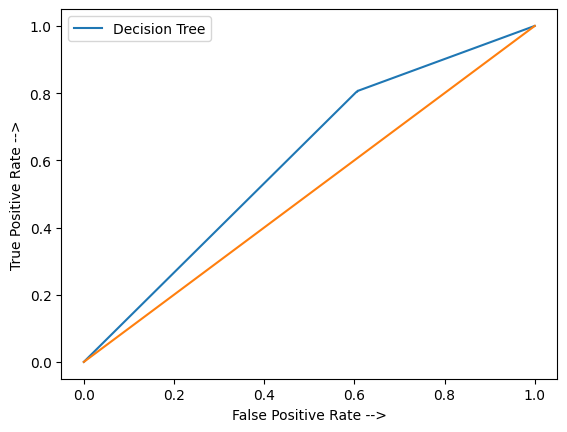

In [12]:
import matplotlib.pyplot as plt
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree") #plots the ROC curve
plt.plot([0,1], [0,1])                                #plots a reference line
plt.legend()                                          #displays the legend
plt.xlabel("False Positive Rate -->")                 #labels the x-axis
plt.ylabel("True Positive Rate -->")                  #labels the y-axis

Now you try...get predicted probabilities for the Random Forest model (`modForest`) and then plot the ROC curve:

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

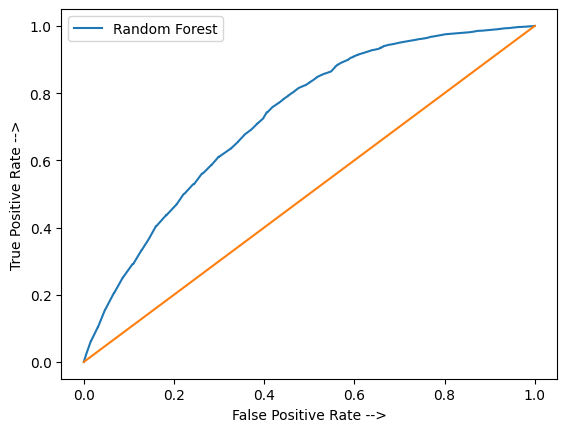

In [13]:
predForest = modForest.predict_proba(featuresTest_norm)
fpr_forest, tpr_forest, threshold_forest = sklearn.metrics.roc_curve(outcomeTest,
                                                             predForest[:, 1],
                                                             pos_label = "Paid")

plt.plot(fpr_forest, tpr_forest, label = "Random Forest")
plt.plot([0,1], [0,1])
plt.legend()
plt.xlabel("False Positive Rate -->")
plt.ylabel("True Positive Rate -->")

Now, copy the `plt.plot()` line of code that drew the Random Forest ROC curve and paste it into the code cell with the Decision Tree ROC curve. See what happens when you combine the code.

Run the following code cell to get the predicted probabilities and ROC curve for the Neural Network model and then copy/paste the `plt.plot()` line of code into the code cell for the Decision Tree above in order to display all 3 curves on top of each other.

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

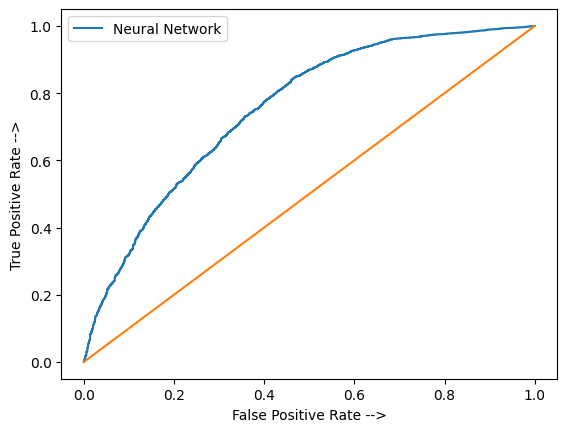

In [14]:
predNN = modNN.predict_proba(featuresTest_norm)
fpr_NN, tpr_NN, threshold_NN = sklearn.metrics.roc_curve(outcomeTest,
                                                     predNN[:, 1],
                                                     pos_label = "Paid")

plt.plot(fpr_NN, tpr_NN, label = "Neural Network")
plt.plot([0,1], [0,1])
plt.legend()
plt.xlabel("False Positive Rate -->")
plt.ylabel("True Positive Rate -->")

For support vector machines, predictions for whether or not a customer `Missed` or `Paid` is based on distance to the support vector plane and not based on probability. Therefore, we need to use `decision_function()` instead of `predict_proba()` to get predictions. This will return 1 number instead of 2, so we also don't need to include `[:, 1]` in the `roc_curve()` command. Other than that, the rest of the code is the same:

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

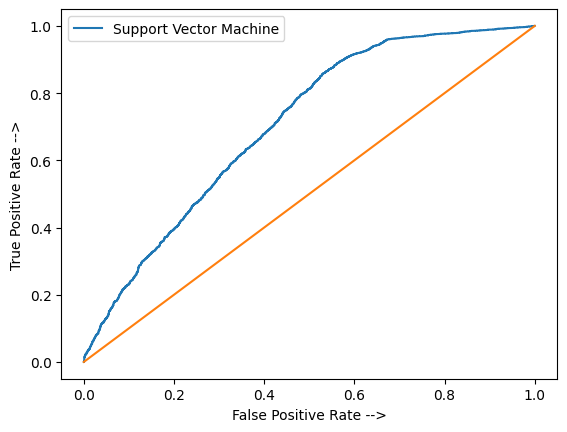

In [15]:
predSVM = modSVM.decision_function(featuresTest_norm)
fpr_SVM, tpr_SVM, threshold_SVM = sklearn.metrics.roc_curve(outcomeTest,
                                                       predSVM,
                                                       pos_label = "Paid")

plt.plot(fpr_SVM, tpr_SVM, label = "Support Vector Machine")
plt.plot([0,1], [0,1])
plt.legend()
plt.xlabel("False Positive Rate -->")
plt.ylabel("True Positive Rate -->")

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

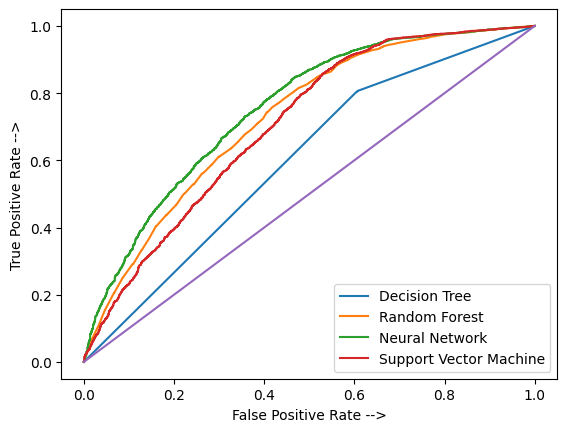

In [16]:
import matplotlib.pyplot as plt
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_forest, tpr_forest, label = "Random Forest")
plt.plot(fpr_NN, tpr_NN, label = "Neural Network")
plt.plot(fpr_SVM, tpr_SVM, label = "Support Vector Machine")
plt.plot([0,1], [0,1])
plt.legend()
plt.xlabel("False Positive Rate -->")
plt.ylabel("True Positive Rate -->")

Based on a comparison of the ROC curves, which model seems to be doing a better job of balancing predictions across the different thresholds?

## AUC (Area under the Curve)

While it's nice to be able to visually compare the ROC curves, the area under the curve (AUC) is a very useful measure to interpret the curve. The AUC is the probability a model will correctly classify the customer. We can use the `auc()` function from `sklearn.metrics` to calculate it: 

In [17]:
auc_tree = sklearn.metrics.auc(fpr_tree, tpr_tree)
auc_tree

0.5998456596890114

We would interpret this as follows: the probability the Decision Tree will correctly classify someone as either `Paid` or `Missed` is 60%.

Now you try...calculate the AUCs for the remaining 3 models. Which model has the highest AUC? Does this make sense based on the ROC curves?

In [18]:
auc_forest = sklearn.metrics.auc(fpr_forest, tpr_forest)
auc_NN = sklearn.metrics.auc(fpr_NN, tpr_NN)
auc_SVM = sklearn.metrics.auc(fpr_SVM, tpr_SVM)

auc_forest
auc_NN
auc_SVM

0.7262665111093181

0.7537558875687158

0.70501784376542

## Youden's J Statistic

Youden's J statistic is an easy way to determine which threshold best balances the true vs. false positive rates. It's calculated as `True Positive Rate - False Positive Rate`.

We can calculate the Youden's J statistic for every threshold used when calculating the `roc_curve()` and then use the corresponding threshold for the highest J statistic. 

Based on the highest AUC, let's find the optimal threshold for the neural network:

In [19]:
# calculate the Youden's J stat for each threshold
Jstat_NN = tpr_NN - fpr_NN

# locate the index location of the highest J stat
import numpy as np
optimal_index = np.argmax(Jstat_NN)

# locate the threshold at that index location
optimal_threshold = threshold_NN[optimal_index] 
optimal_threshold

0.7337956821276903

This suggests that, if we use the neural network model, any prediction with a probability less than 0.734 should be classified as `Missed` and anything above that threshold should be classified as `Paid`.

Here's how to get the new classification report based on this threshold:

In [20]:
# recalculate predictions using the optimal threshold
predNN_optimal = (predNN[:, 1] >= optimal_threshold)

# convert the predicted True/False values to "Paid" or "Missed"
predNN_optimal = np.array(["Paid" if pred == True else "Missed" for pred in predNN_optimal])

# print the classification report
print(sklearn.metrics.classification_report(outcomeTest, predNN_optimal))

              precision    recall  f1-score   support

      Missed       0.49      0.53      0.51      2158
        Paid       0.87      0.85      0.86      7742

    accuracy                           0.78      9900
   macro avg       0.68      0.69      0.68      9900
weighted avg       0.79      0.78      0.78      9900



As a reminder, here's the original classification report using a 50% threshold:

In [21]:
predNN_original = modNN.predict(featuresTest_norm)
print(sklearn.metrics.classification_report(outcomeTest, predNN_original))

              precision    recall  f1-score   support

      Missed       0.66      0.34      0.45      2158
        Paid       0.84      0.95      0.89      7742

    accuracy                           0.82      9900
   macro avg       0.75      0.64      0.67      9900
weighted avg       0.80      0.82      0.79      9900



The overall accuracy of the model decreased from 82% to 78%. However, notice the F1 score for the `Missed` category increased from 45% to 51%. 

If it's more costly to the bank to misclassify customers who miss their payments, the increased F1 score on `Missed` customers may outweigh the decreased overall accuracy.

# Another Example

For practice, see if you can build Decision Tree, Random Forest, SVM, and Neural Network models using the `diabetes.csv` data set and then evaluate the models using ROC curves, AUC, and Youden's J statistic. For your models, use the variable `Outcome` as your outcome variable and all other variables as your features. (For the neural network model, use `hidden_layer_sizes = (40,40)` and include `max_iter = 1000` as a parameter.)

In [23]:
df2 = pd.read_csv("diabetes.csv")
df2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [24]:
outcome2 = df2["Outcome"]
features2 = df2[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
              "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]
featuresTrain2, featuresTest2, outcomeTrain2, outcomeTest2 = train_test_split(features2,
                                                                         outcome2,
                                                                         test_size = 0.33,
                                                                         random_state = 42)

In [25]:
scaler2 = MinMaxScaler()
featuresTrainNorm = scaler2.fit_transform(featuresTrain2)
featuresTestNorm = scaler2.transform(featuresTest2)

In [26]:
modTree2 = sklearn.tree.DecisionTreeClassifier(random_state = 42)
modTree2.fit(featuresTrainNorm, outcomeTrain2)
predTree2 = modTree2.predict_proba(featuresTestNorm)

modForest2 = sklearn.ensemble.RandomForestClassifier(random_state = 42)
modForest2.fit(featuresTrainNorm, outcomeTrain2)
predForest2 = modForest2.predict_proba(featuresTestNorm)

modSVM2 = sklearn.svm.SVC(random_state = 42)
modSVM2.fit(featuresTrainNorm, outcomeTrain2)
predSVM2 = modSVM2.decision_function(featuresTestNorm)

modNN2 = sklearn.neural_network.MLPClassifier(random_state = 42, 
                                              hidden_layer_sizes = (40,40),
                                             max_iter = 1000)
modNN2.fit(featuresTrainNorm, outcomeTrain2)
predNN2 = modNN2.predict_proba(featuresTestNorm)

DecisionTreeClassifier(random_state=42)

RandomForestClassifier(random_state=42)

SVC(random_state=42)

MLPClassifier(hidden_layer_sizes=(40, 40), max_iter=1000, random_state=42)

In [27]:
fpr_tree2, tpr_tree2, threshold_tree2 = sklearn.metrics.roc_curve(outcomeTest2,
                                                                 predTree2[:, 1],
                                                                 pos_label = 1)

fpr_forest2, tpr_forest2, threshold_forest2 = sklearn.metrics.roc_curve(outcomeTest2,
                                                                 predForest2[:, 1],
                                                                 pos_label = 1)

fpr_SVM2, tpr_SVM2, threshold_SVM2 = sklearn.metrics.roc_curve(outcomeTest2,
                                                                 predSVM2,
                                                                 pos_label = 1)

fpr_NN2, tpr_NN2, threshold_NN2 = sklearn.metrics.roc_curve(outcomeTest2,
                                                                 predNN2[:, 1],
                                                                 pos_label = 1)

In [28]:
auc_tree2 = sklearn.metrics.auc(fpr_tree2, tpr_tree2)
auc_forest2 = sklearn.metrics.auc(fpr_forest2, tpr_forest2)
auc_SVM2 = sklearn.metrics.auc(fpr_SVM2, tpr_SVM2)
auc_NN2 = sklearn.metrics.auc(fpr_NN2, tpr_NN2)

Text(0.5, 0, 'False Positive Rate -->')

Text(0, 0.5, 'True Positive Rate -->')

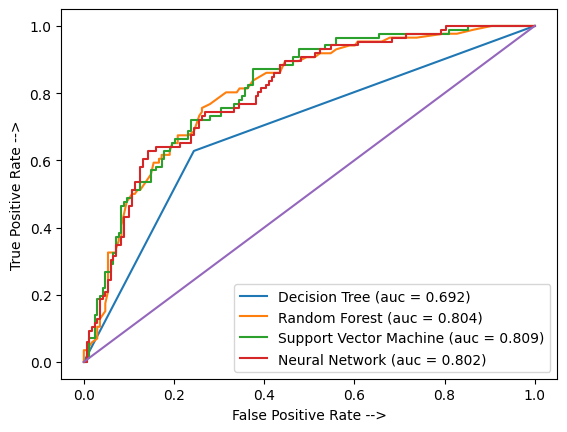

In [29]:
plt.plot(fpr_tree2, tpr_tree2, label = "Decision Tree (auc = %0.3f)" %auc_tree2)
plt.plot(fpr_forest2, tpr_forest2, label = "Random Forest (auc = %0.3f)" %auc_forest2)
plt.plot(fpr_SVM2, tpr_SVM2, label = "Support Vector Machine (auc = %0.3f)" %auc_SVM2)
plt.plot(fpr_NN2, tpr_NN2, label = "Neural Network (auc = %0.3f)" %auc_NN2)
plt.plot([0,1], [0,1])
plt.legend()
plt.xlabel("False Positive Rate -->")
plt.ylabel("True Positive Rate -->")

The Support Vector Machine model has the highest AUC, suggesting that it has an 80.9% probability of correctly classifying whether or not someone has diabetes.

In [30]:
Jstat_SVM = tpr_SVM2 - fpr_SVM2
optimal_index2 = np.argmax(Jstat_SVM)
optimal_threshold2 = threshold_SVM2[optimal_index2] 
optimal_threshold2

-0.7555084571046484

Remember that, for SVM models, classification is based on distance from the support vector line (or plane) and not probability. This is why the optimal threshold is a negative number. 

To get new predictions, you'd compare the predictions on the test data to the threshold and classify each observation as a 0 or 1. Here's the classification report using the optimal threshold:

In [31]:
new_predictions = (predSVM2 >= optimal_threshold2).astype(int)
print(sklearn.metrics.classification_report(outcomeTest2, new_predictions))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       168
           1       0.54      0.87      0.67        86

    accuracy                           0.71       254
   macro avg       0.72      0.75      0.70       254
weighted avg       0.78      0.71      0.72       254



Again, let's compare to the classification report based on default predictions (with a threshold of 0):

In [32]:
predSVMTest2 = modSVM2.predict(featuresTestNorm)
print(sklearn.metrics.classification_report(outcomeTest2, predSVMTest2))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       168
           1       0.64      0.57      0.60        86

    accuracy                           0.75       254
   macro avg       0.72      0.70      0.71       254
weighted avg       0.74      0.75      0.74       254



As with the credit card model above, the overall accuracy decreases slightly (from 75% to 71%) when using the optimal threshold. But we can see that the predictions for whether or not someone has diabetes (a value of `1`) increases from an F1 score of 60% to 67%.